# Homework: Sentiment analysis

Для заданной тестовой выборки построить модель для предсказания тональности твита.  
На заданном разбиении (df_train, df_test) ваша модель должна превзойти baseline'ы, приведенные ниже.  

Чем больше baseline'ов вы превзойдете, тем выше ваша оценка.  
Метрика качества f1 (f1_macro) (чем больше, тем лучше)

baseline 0: 0.3319      random  
baseline 1: 0.6941      text norm + word embedding + logistic regression
baseline 2: 0.6990      tf-idf over words + logistic regression  
baseline 3: 0.7418      tf-idf over symbols + logistic regression  

Пока мы рассмотрели только линейные модели - поэтому в примерах есть только они. Желательно при решении домашнего задания пользоваться линейными моделями. Таким образом, основные цели задания - feature engineering, hyperparam tuning & model selection.

! Your results must be reproducible. Если ваша модель - стохастическая, то вы явно должны задавать все seed и random_state в параметрах моделей  
! Вы должны использовать df_test только для измерения качества конечной обученной модели. 

bonus, think about:
1. why we selected f1 with macro averaging as our classification quality measure instead of others? look in docs  
2. why word embeddings perform so poorly with linear models?  
3. other ideas how to get text2vec from word2vec. look in docs  

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


SEED = 1337


df = pd.read_csv('Tweets.csv')

## Look at the data

In [2]:
df.head()

,tweet_id,airline_sentiment,airline,retweet_count,text
0,570306133677760513,neutral,Virgin America,0,@VirginAmerica What @dhepburn said.
1,570301130888122368,positive,Virgin America,0,@VirginAmerica plus you've added commercials t...
2,570301083672813571,neutral,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...
3,570301031407624196,negative,Virgin America,0,@VirginAmerica it's really aggressive to blast...
4,570300817074462722,negative,Virgin America,0,@VirginAmerica and it's a really big bad thing...


In [3]:
# main reason we have chosen f1 is that class distribution is imbalanced
df.airline_sentiment.value_counts(normalize=True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

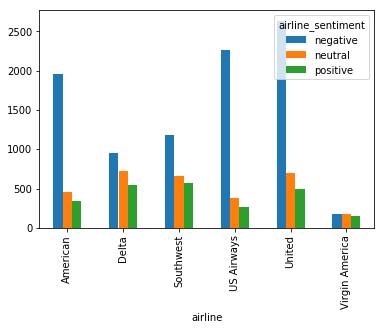

In [4]:
# class distribution over airlines
pd.pivot_table(df, index='airline', values='tweet_id', columns='airline_sentiment', aggfunc='count').plot.bar();

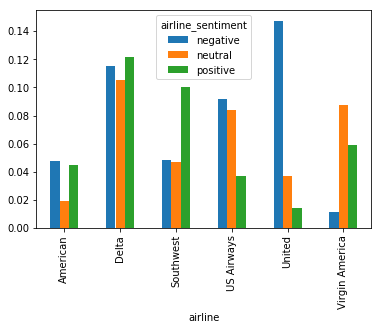

In [5]:
# mean retweet count distribution
pd.pivot_table(df, index='airline', values='retweet_count', columns='airline_sentiment', aggfunc='mean').plot.bar();

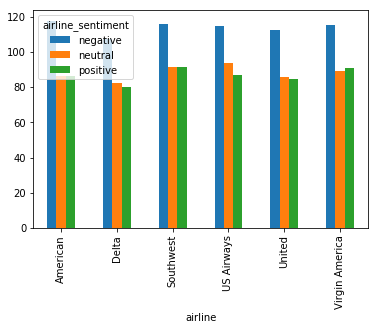

In [6]:
# mean text length distribution
df['text_len'] = df.text.apply(len)
pd.pivot_table(df, index='airline', values='text_len', columns='airline_sentiment', aggfunc='mean').plot.bar();

## Baselines

In [7]:
def add_metrics(metrics, value, name):
    metrics.loc[name, 'f1'] = value
best_metrics = pd.DataFrame()

In [8]:
# we can notice that negative < neutral < positive
# let's encode that appropreately
df.loc[df.airline_sentiment == 'negative', 'airline_sentiment'] = 0
df.loc[df.airline_sentiment == 'neutral', 'airline_sentiment'] = 1
df.loc[df.airline_sentiment == 'positive', 'airline_sentiment'] = 2

In [9]:
# encode airline as categorial variable
airline_le = LabelEncoder()
df['airline'] = airline_le.fit_transform(df.airline)
df.head()

,tweet_id,airline_sentiment,airline,retweet_count,text,text_len
0,570306133677760513,1,5,0,@VirginAmerica What @dhepburn said.,35
1,570301130888122368,2,5,0,@VirginAmerica plus you've added commercials t...,72
2,570301083672813571,1,5,0,@VirginAmerica I didn't today... Must mean I n...,71
3,570301031407624196,0,5,0,@VirginAmerica it's really aggressive to blast...,126
4,570300817074462722,0,5,0,@VirginAmerica and it's a really big bad thing...,55


In [10]:
y = df.airline_sentiment.values
df_train, df_test, y_train, y_test = train_test_split(df, y, test_size=0.25, 
                                                                      stratify=y,
                                                                      random_state=SEED, 
                                                                      shuffle=True)
print('train', df_train.shape[0])
print('test', df_test.shape[0])

train 10980
test 3660


#### Baseline 0. Dummy Classifier.

In [11]:
%%time
# baseline 0
# Assigns random class label
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

#DummyClassifier is a classifier that makes predictions using simple rules.
#This classifier is useful as a simple baseline to compare with other (real) classifiers.

model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('est', DummyClassifier(strategy='stratified', random_state=SEED))
])

model.fit(df_train.text, y_train)
print('train', metrics.f1_score(y_train, model.predict(df_train.text), average='macro'))
print('test', metrics.f1_score(y_test, model.predict(df_test.text), average='macro'))

train 0.3365976016519445
test 0.33195996490372054
CPU times: user 703 ms, sys: 19.1 ms, total: 722 ms
Wall time: 726 ms


In [12]:
add_metrics(best_metrics, metrics.f1_score(y_test, model.predict(df_test.text), average='macro'), 'baseline_0')
best_metrics

,f1
baseline_0,0.33196


In [13]:
from sklearn.base import TransformerMixin
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import string
import re


# create wrapper for basic text preprocessing
# make lowercase, remove punctuation and make stemming

# all transformers (that transform data) must inherit from sklearn.base.TransformerMixin
# all classifiers  must inherit from sklearn.base.ClassifierMixin
class TextNormalizer(TransformerMixin):
    def __init__(self, stop_words=stopwords.words('english'), 
                 stemmer=SnowballStemmer("english")):
        self.stop_words_ = stop_words
        self.stemmer_ = stemmer
        self.regex_ = re.compile('[%s]' % re.escape(string.punctuation))

    # by convention, must return self
    def fit(self, X, y):
        return self
    
    def _normalize(self, text):
        text = text.lower()
        text = self.regex_.sub(' ', text)
        text = [self.stemmer_.stem(word) for word in text.split() if word not in self.stop_words_]
        return " ".join(text)

    def transform(self, X):
        return np.array(list(map(lambda x: self._normalize(x), X)))

In [14]:
s = 'This film is awful, but I like it anyway.'
tn = TextNormalizer()
X = tn.transform(df_train.text)

In [15]:
X[:5]

array(['americanair serious treat passeng like shit',
       'jetblu 1st flight morn fli toddler plane heat comfort temp board start itscold',
       'unit think guy half full flight 4 held overbook 3pm flight fill one cancel flightl mine',
       'americanair heard back 7 30 today put flight tomorrow arriv home 4 pm mean take 2nd day work',
       'southwestair know plane come sw flight 4464 rsw mke'],
      dtype='<U131')

In [16]:
# some wrappers to work with word2vec
from gensim.models.word2vec import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
#from glove import Corpus, Glove


# convert words from tweet to vectors and average them over tweet
# or use weighted average according to idf
class Text2Vec(TransformerMixin):
    def __init__(self, vectorizer, use_idf=False):
        self.use_idf_ = use_idf
        self.w2v = vectorizer
        self.size_ = self.w2v.get_size()
        self.weights_ = None

    def fit(self, X, y=None):
        self.w2v.fit(X)
        
        if self.use_idf_:
            tfidf = TfidfVectorizer(analyzer=lambda x: x)
            tfidf.fit(X)
            # if a word was never seen - it must be at least as infrequent
            # as any of the known words - so the default idf is the max of known idf's
            max_idf = max(tfidf.idf_)
            self.weights_ = defaultdict(lambda: max_idf, [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        if self.w2v is None:
            raise Exception('model not fitted')
            
        if self.use_idf_:
            if self.weights_ is None:
                raise Exception('model not fitted')
                
            result = np.array([np.mean([self.w2v.transform(w) * self.weights_[w] for w in sentence.split() if self.w2v.has(w)]
                                       or [np.zeros(self.size_)], axis=0) for sentence in X])
        else:
            result = np.array([np.mean([self.w2v.transform(w) for w in sentence.split() if self.w2v.has(w)] 
                                       or [np.zeros(self.size_)], axis=0) for sentence in X])
        return result
    
    
class Word2VecWrapper(TransformerMixin):
    def __init__(self, window=5,negative=5, size=100, iter=100, is_cbow=False, random_state=SEED):
        self.window_ = window
        self.negative_ = negative
        self.size_ = size
        self.iter_ = iter
        self.is_cbow_ = is_cbow
        self.w2v = None
        self.random_state = random_state
        
    def get_size(self):
        return self.size_

    def fit(self, X, y=None):
        """
        X: list of strings
        """
        sentences_list = [x.split() for x in X]
        self.w2v = Word2Vec(sentences_list, 
                            window=self.window_,
                            negative=self.negative_, 
                            size=self.size_, 
                            iter=self.iter_,
                            sg=not self.is_cbow_, seed=self.random_state)

        return self
    
    def has(self, word):
        return word in self.w2v

    def transform(self, X):
        """
        X: a word
        """
        if self.w2v is None:
            raise Exception('model not fitted')
        return self.w2v[X] if X in self.w2v else np.zeros(self.size_)
    

class GloveWrapper(TransformerMixin):
    def __init__(self, window=5, learning_rate=0.05, size=100, epochs=100, random_state=SEED, verbose=False):
        self.window_ = window
        self.learning_rate_ = learning_rate
        self.size_ = size
        self.epochs_ = epochs
        self.glove = None
        self.random_state = random_state
        self.verbose_ = verbose
    
    def get_size(self):
        return self.size_

    def fit(self, X, y=None):
        """
        X: list of strings
        """
        sentences_list = [x.split() for x in X]
        corpus = Corpus()
        corpus.fit(sentences_list, window=self.window_)
        self.glove = Glove(no_components=self.size_, 
                           learning_rate=self.learning_rate_, 
                           random_state=self.random_state)
        self.glove.fit(corpus.matrix, 
                  epochs=self.epochs_, 
                  no_threads=4, verbose=self.verbose_)
        self.glove.add_dictionary(corpus.dictionary)
        return self
    
    def has(self, word):
        return word in self.glove.dictionary

    def transform(self, X):
        if self.glove is None:
            raise Exception('model not fitted')
            
        return self.glove.word_vectors[self.glove.dictionary[X]] if X in self.glove.dictionary else np.zeros(self.size_)

    
class WordEmbeddingFabric:
    @classmethod
    def create(cls, method, size, cbow, n_iter=300):
        if method == 'word2vec':
            return Word2VecWrapper(window=3, negative=5, size=size, iter=n_iter, is_cbow=cbow)
                    
        if method == 'glove':
            return GloveWrapper(window=3, learning_rate=0.05, size=size, epochs=n_iter, verbose=False)

In [17]:
%%time
# baseline 2
# simple tf-idf over words + logistic regression

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords


model = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', use_idf=True, smooth_idf=True,
                                  lowercase=True, 
                                  stop_words=stopwords.words('english'),
                                  min_df=5,
                                  ngram_range=(1,2), norm='l2')),
    ('est', LogisticRegressionCV(Cs=10, 
                                    cv=5, 
                                    scoring='f1_macro', 
                                    n_jobs=-1, 
                                    multi_class='multinomial', random_state=SEED))
])

model.fit(df_train.text, y_train)
print('train', metrics.f1_score(y_train, model.predict(df_train.text), average='macro'))
print('test', metrics.f1_score(y_test, model.predict(df_test.text), average='macro'))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in l

train 0.8634104347906314
test 0.6990703425659087
CPU times: user 2.01 s, sys: 87.8 ms, total: 2.1 s
Wall time: 12.3 s


In [18]:
add_metrics(best_metrics, metrics.f1_score(y_test, model.predict(df_test.text), average='macro'), 'baseline_2')
best_metrics

,f1
baseline_0,0.33196
baseline_2,0.69907


In [19]:
%%time
# baseline 3
# simple tf-idf over symbols + logistic regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords


model = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='char', use_idf=True, smooth_idf=True,
                                  lowercase=True, 
                                  stop_words=stopwords.words('english'),
                                  min_df=5,
                                  ngram_range=(1,3), norm='l2')),
    ('est', LogisticRegressionCV(Cs=10, 
                                    cv=5, 
                                    scoring='f1_macro', 
                                    n_jobs=-1, 
                                    multi_class='multinomial', random_state=SEED))
])

model.fit(df_train.text, y_train)
print('train', metrics.f1_score(y_train, model.predict(df_train.text), average='macro'))
print('test', metrics.f1_score(y_test, model.predict(df_test.text), average='macro'))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in l

train 0.8640062878925994
test 0.7418129255654868
CPU times: user 9.58 s, sys: 312 ms, total: 9.9 s
Wall time: 1min 7s


In [20]:
add_metrics(best_metrics, metrics.f1_score(y_test, model.predict(df_test.text), average='macro'), 'baseline_3')
best_metrics

,f1
baseline_0,0.331960
baseline_2,0.699070
baseline_3,0.741813


In [39]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

svc = LinearSVC(multi_class='ovr')
#     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
#     multi_class='ovr',tol=0.00001,verbose=10,random_state=SEED)

params = {'penalty':['l1','l2'],
         'C': [1.e-4, 1.e-3, 1.e-2, 1.e-1, 1, 2, 10, 100],
          'tol': [1.e-4, 1.e-3, 1.e-2, 1.e-1, 1],
          'class_weight': ['balanced', None]
         }

model = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='char', use_idf=True, smooth_idf=True,
                                  lowercase=True, 
                                  stop_words=stopwords.words('english'),
                                  min_df=5,
                                  ngram_range=(1,3), norm='l2')),
    ('est', GridSearchCV(svc, params, cv=5, verbose=10, scoring='f1_macro', error_score=0))])

model.fit(df_train.text, y_train)
print('train', metrics.f1_score(y_train, model.predict(df_train.text), average='macro'))
print('test', metrics.f1_score(y_test, model.predict(df_test.text), average='macro'))

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=0.0001 .........
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=0.0001 .........
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=0.0001 .........
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=0.0001 .........
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=0.0001 .........
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=0.001 ..........
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='

[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=0.001 ..........
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=0.001 ..........
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=0.001 ..........
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=0.01 ...........
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=0.01 ...........
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=0.01 ...........
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.01, score

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='

[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=0.01 ...........
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=0.1 ............
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=0.1 ............
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=0.1 ............
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=0.1 ............
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=0.1 ............
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=0.1, score=0, total

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=1 ..............
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=1 ..............
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=1 ..............
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l1, tol=1 ..............
[CV]  C=0.0001, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.0001 .........


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.0001, score=0.2568550643536654, total=   0.3s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.0001 .........


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.0001, score=0.2568550643536654, total=   0.3s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.0001 .........


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.0001, score=0.25692695214105793, total=   0.3s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.0001 .........


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.0001, score=0.25692695214105793, total=   0.3s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.0001 .........


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.0001, score=0.25695611577964517, total=   0.3s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.001 ..........


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.001, score=0.2568550643536654, total=   0.2s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.001 ..........


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.001, score=0.2568550643536654, total=   0.3s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.001 ..........


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.001, score=0.25692695214105793, total=   0.2s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.001 ..........


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.001, score=0.25692695214105793, total=   0.3s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.001 ..........


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.001, score=0.25695611577964517, total=   0.3s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.01 ...........


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.01, score=0.2568550643536654, total=   0.2s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.01 ...........
[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.01, score=0.2568550643536654, total=   0.2s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.01 ...........


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.01, score=0.25692695214105793, total=   0.2s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.01 ...........


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.01, score=0.25692695214105793, total=   0.2s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.01 ...........


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.01, score=0.25695611577964517, total=   0.3s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.1 ............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.1, score=0.2568550643536654, total=   0.2s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.1 ............
[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.1, score=0.2568550643536654, total=   0.2s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.1 ............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.1, score=0.25692695214105793, total=   0.2s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.1 ............
[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.1, score=0.25692695214105793, total=   0.2s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=0.1 ............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=0.1, score=0.25695611577964517, total=   0.2s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=1 ..............
[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=1, score=0.2568550643536654, total=   0.1s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=1 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=1, score=0.2568550643536654, total=   0.1s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=1 ..............
[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=1, score=0.25692695214105793, total=   0.1s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=1 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Detai

[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=1, score=0.25692695214105793, total=   0.1s
[CV] C=0.0001, class_weight=balanced, penalty=l2, tol=1 ..............
[CV]  C=0.0001, class_weight=balanced, penalty=l2, tol=1, score=0.25695611577964517, total=   0.1s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.0001 .............
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.0001 .............
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.0001 .............
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.0001 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.0001 .............
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.001 ..............
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.001 ..............
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.001 ..............
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.001 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.001 ..............
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.01 ...............
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.01 ...............
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.01 ...............
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.01 ...............
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.01 ...............
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi


[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.1 ................
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.1 ................
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.1 ................
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.1 ................
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=0.1 ................
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=1 ..................
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=1 ..................
[CV]  C=0.0001, class_weight=N

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.0001, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=1 ..................
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l1, tol=1 ..................
[CV]  C=0.0001, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.0001 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.0001, score=0.2568550643536654, total=   0.3s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.0001 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.0001, score=0.2568550643536654, total=   0.3s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.0001 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.0001, score=0.25692695214105793, total=   0.3s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.0001 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.0001, score=0.25692695214105793, total=   0.3s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.0001 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.0001, score=0.25695611577964517, total=   0.3s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.001 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.001, score=0.2568550643536654, total=   0.3s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.001 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.001, score=0.2568550643536654, total=   0.3s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.001 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.001, score=0.25692695214105793, total=   0.3s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.001 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.001, score=0.25692695214105793, total=   0.3s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.001 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.001, score=0.25695611577964517, total=   0.3s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.01 ...............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.01, score=0.2568550643536654, total=   0.2s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.01 ...............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.01, score=0.2568550643536654, total=   0.2s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.01 ...............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.01, score=0.25692695214105793, total=   0.3s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.01 ...............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.01, score=0.25692695214105793, total=   0.2s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.01 ...............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.01, score=0.25695611577964517, total=   0.2s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.1 ................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.1, score=0.2568550643536654, total=   0.2s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.1 ................
[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.1, score=0.2568550643536654, total=   0.2s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.1 ................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.1, score=0.25692695214105793, total=   0.2s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.1 ................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.1, score=0.25692695214105793, total=   0.2s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=0.1 ................
[CV]  C=0.0001, class_weight=None, penalty=l2, tol=0.1, score=0.25695611577964517, total=   0.2s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=1 ..................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=1, score=0.2568550643536654, total=   0.1s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=1 ..................
[CV]  C=0.0001, class_weight=None, penalty=l2, tol=1, score=0.2568550643536654, total=   0.1s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=1 ..................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=None, penalty=l2, tol=1, score=0.25692695214105793, total=   0.1s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=1 ..................
[CV]  C=0.0001, class_weight=None, penalty=l2, tol=1, score=0.25692695214105793, total=   0.2s
[CV] C=0.0001, class_weight=None, penalty=l2, tol=1 ..................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters

[CV]  C=0.0001, class_weight=None, penalty=l2, tol=1, score=0.25695611577964517, total=   0.2s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.0001 ..........
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.0001 ..........
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.0001 ..........
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.0001 ..........
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.0001 ..........
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.001 ...........


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.001 ...........
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.001 ...........
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.001 ...........
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.001 ...........
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.01 ............
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.01 ............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.01 ............
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.01 ............
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.01 ............
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.1 .............
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.1 .............
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.1 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.1 .............
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=0.1 .............
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=1 ...............
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=1 ...............
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=1 ...............
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=1 ...............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l1, tol=1 ...............
[CV]  C=0.001, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.001, class_weight=balanced, penalty=l2, tol=0.0001 ..........
[CV]  C=0.001, class_weight=balanced, penalty=l2, tol=0.0001, score=0.3910886772337126, total=   0.2s
[CV] C=0.001, class_weight=balanced, penalty=l2, tol=0.0001 ..........
[CV]  C=0.001, class_weight=balanced, penalty=l2, tol=0.0001, score=0.37510950865395354, total=   0.2s
[CV] C=0.001, class_weight=balanced, penalty=l2, tol=0.0001 ..........
[CV]  C=0.001, class_weight=balanced, penalty=l2, tol=0.0001, score=0.3831748642320323, total=   0.3s
[CV] C=0.001, class_weight=balanced, penalty=l2, tol=0.0001 ..........
[CV]  C=0.001, class_weight=balanced, penalty=l2, tol=0.0001, score=0.36655291475757384, total=   0.3s
[CV] C=0.001, class_weight=balanced, penalty=l2, tol=0.0001 ..........
[CV]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.001, class_weight=None, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l1, tol=0.0001 ..............
[CV]  C=0.001, class_weight=None, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l1, tol=0.0001 ..............
[CV]  C=0.001, class_weight=None, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l1, tol=0.001 ...............
[CV]  C=0.001, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l1, tol=0.001 ...............
[CV]  C=0.001, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l1, tol=0.001 ...............
[CV]  C=0.001, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l1, tol=0.001 ...............
[CV]  C=0.001, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.00

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.001, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l1, tol=0.01 ................
[CV]  C=0.001, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l1, tol=0.01 ................
[CV]  C=0.001, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l1, tol=0.01 ................
[CV]  C=0.001, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l1, tol=0.01 ................
[CV]  C=0.001, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l1, tol=0.01 ................
[CV]  C=0.001, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l1, tol=0.1 .................
[CV]  C=0.001, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.001, class_w

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.001, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l1, tol=0.1 .................
[CV]  C=0.001, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l1, tol=0.1 .................
[CV]  C=0.001, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l1, tol=0.1 .................
[CV]  C=0.001, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l1, tol=1 ...................
[CV]  C=0.001, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l1, tol=1 ...................
[CV]  C=0.001, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l1, tol=1 ...................
[CV]  C=0.001, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, p

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.001, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l1, tol=1 ...................
[CV]  C=0.001, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.001, class_weight=None, penalty=l2, tol=0.0001 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.0001, score=0.2568550643536654, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=0.0001 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.0001, score=0.2568550643536654, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=0.0001 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.0001, score=0.25692695214105793, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=0.0001 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.0001, score=0.25692695214105793, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=0.0001 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.0001, score=0.25695611577964517, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=0.001 ...............
[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.001, score=0.2568550643536654, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=0.001 ...............
[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.001, score=0.2568550643536654, total=   0.2s

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



[CV] C=0.001, class_weight=None, penalty=l2, tol=0.001 ...............
[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.001, score=0.25692695214105793, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=0.001 ...............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.001, score=0.25692695214105793, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=0.001 ...............
[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.001, score=0.25695611577964517, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=0.01 ................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.01, score=0.2568550643536654, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=0.01 ................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.01, score=0.2568550643536654, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=0.01 ................
[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.01, score=0.25692695214105793, total=   0.1s
[CV] C=0.001, class_weight=None, penalty=l2, tol=0.01 ................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.01, score=0.25692695214105793, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=0.01 ................
[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.01, score=0.25695611577964517, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=0.1 .................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.1, score=0.2568550643536654, total=   0.1s
[CV] C=0.001, class_weight=None, penalty=l2, tol=0.1 .................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.1, score=0.2568550643536654, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=0.1 .................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.1, score=0.25692695214105793, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=0.1 .................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.1, score=0.25692695214105793, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=0.1 .................
[CV]  C=0.001, class_weight=None, penalty=l2, tol=0.1, score=0.25695611577964517, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=1 ...................
[CV]  C=0.001, class_weight=None, penalty=l2, tol=1, score=0.2568550643536654, total=   0.1s
[CV] C=0.001, class_weight=None, penalty=l2, tol=1 ...................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, class_weight=None, penalty=l2, tol=1, score=0.2568550643536654, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=1 ...................
[CV]  C=0.001, class_weight=None, penalty=l2, tol=1, score=0.25692695214105793, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=1 ...................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, class_weight=None, penalty=l2, tol=1, score=0.25692695214105793, total=   0.2s
[CV] C=0.001, class_weight=None, penalty=l2, tol=1 ...................
[CV]  C=0.001, class_weight=None, penalty=l2, tol=1, score=0.25695611577964517, total=   0.1s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=0.0001 ...........
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=0.0001 ...........


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters

[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=0.0001 ...........
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=0.0001 ...........
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=0.0001 ...........
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=0.001 ............
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=0.001 ............
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=0.001 ............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=0.001 ............
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=0.001 ............
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=0.01 .............
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=0.01 .............
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=0.01 .............
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=0.01 .............
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=0.1 ..............
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=0.1 ..............
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=0.1 ..............
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=0.1 ..............
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=0.1 ..............
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=1 ................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=1 ................
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=1 ................
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=1 ................
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l1, tol=1 ................
[CV]  C=0.01, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.01, class_weight=balanced, penalty=l2, tol=0.0001 ...........
[CV]  C=0.01, class_weight=balanced, penalty=l2, tol=0.0001, score=0.6489743165459122, total=   0.4s
[CV] C=0.01, class_weight=balanced, penalty=l2, tol=0.0001 ...........
[CV]  C=0.01, class_weight=balanced, penalty=l2, tol=0.0001, score=0.635862825

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.01, class_weight=None, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=0.0001 ...............
[CV]  C=0.01, class_weight=None, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=0.0001 ...............
[CV]  C=0.01, class_weight=None, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=0.0001 ...............
[CV]  C=0.01, class_weight=None, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=0.001 ................
[CV]  C=0.01, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=0.001 ................
[CV]  C=0.01, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=0.001 ................
[CV]  C=0.01, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.01, clas

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.01, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=0.001 ................
[CV]  C=0.01, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=0.01 .................
[CV]  C=0.01, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=0.01 .................
[CV]  C=0.01, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=0.01 .................
[CV]  C=0.01, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=0.01 .................
[CV]  C=0.01, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=0.01 .................
[CV]  C=0.01, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.01, class_weight=

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.01, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=0.1 ..................
[CV]  C=0.01, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=0.1 ..................
[CV]  C=0.01, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=0.1 ..................
[CV]  C=0.01, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=0.1 ..................
[CV]  C=0.01, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=1 ....................
[CV]  C=0.01, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=1 ....................
[CV]  C=0.01, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.01, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=1 ....................
[CV]  C=0.01, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l1, tol=1 ....................
[CV]  C=0.01, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.01, class_weight=None, penalty=l2, tol=0.0001 ...............
[CV]  C=0.01, class_weight=None, penalty=l2, tol=0.0001, score=0.5036944808311389, total=   0.4s
[CV] C=0.01, class_weight=None, penalty=l2, tol=0.0001 ...............
[CV]  C=0.01, class_weight=None, penalty=l2, tol=0.0001, score=0.49962090423858885, total=   0.4s
[CV] C=0.01, class_weight=None, penalty=l2, tol=0.0001 ...............
[CV]  C=0.01, class_weight=None, penalty=l2, tol=0.0001, score=0.5197190544001141, total=   0.4s
[CV] C=0.01, class_weight=None, penalty=l2, tol=0.0001 ...............
[CV]  C=0.01, class_weight=None, penalty=l2, tol=0.0001, 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=0.0001 ............
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=0.0001 ............
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=0.0001 ............
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=0.0001 ............
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=0.001 .............
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=0.001 .............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=0.001 .............
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=0.001 .............
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=0.001 .............
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=0.01 ..............
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=0.01 ..............
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=0.01 ..............
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV] C=0.1, class_weight=balanced, penalty=l1, tol=0.01 ..............
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=0.01 ..............
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=0.1 ...............
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=0.1 ...............
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=0.1 ...............
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=0.1 ...............
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=0.1 ...............
[CV]  C=0.1, class_we

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=1 .................
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=1 .................
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=1 .................
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l1, tol=1 .................
[CV]  C=0.1, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.1, class_weight=balanced, penalty=l2, tol=0.0001 ............
[CV]  C=0.1, class_weight=balanced, penalty=l2, tol=0.0001, score=0.7449322444369, total=   0.4s
[CV] C=0.1, class_weight=balanced, penalty=l2, tol=0.0001 ............
[CV]  C=0.1, class_weight=balanced, penalty=l2, tol=0.0001, score=0.7324190391649855, t

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.1, class_weight=None, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=0.0001 ................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=0.0001 ................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=0.0001 ................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=0.001 .................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=0.001 .................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=0.001 .................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.1, class_weight

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.1, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=0.001 .................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=0.01 ..................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=0.01 ..................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=0.01 ..................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=0.01 ..................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=0.01 ..................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, pe

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.1, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=0.1 ...................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=0.1 ...................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=0.1 ...................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=0.1 ...................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=1 .....................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=1 .....................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=0.1, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=1 .....................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l1, tol=1 .....................
[CV]  C=0.1, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=0.1, class_weight=None, penalty=l2, tol=0.0001 ................
[CV]  C=0.1, class_weight=None, penalty=l2, tol=0.0001, score=0.6894869833143978, total=   0.3s
[CV] C=0.1, class_weight=None, penalty=l2, tol=0.0001 ................
[CV]  C=0.1, class_weight=None, penalty=l2, tol=0.0001, score=0.6836277358413353, total=   0.3s
[CV] C=0.1, class_weight=None, penalty=l2, tol=0.0001 ................
[CV]  C=0.1, class_weight=None, penalty=l2, tol=0.0001, score=0.7158777118367082, total=   0.4s
[CV] C=0.1, class_weight=None, penalty=l2, tol=0.0001 ................
[CV]  C=0.1, class_weight=None, penalty=l2, tol=0.0001, score=0.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=1, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=0.0001 ..............
[CV]  C=1, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=0.0001 ..............
[CV]  C=1, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=0.0001 ..............
[CV]  C=1, class_weight=balanced, penalty=l1, tol=0.0001, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=0.001 ...............
[CV]  C=1, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=0.001 ...............
[CV]  C=1, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=0.001 ...............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=1, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=0.001 ...............
[CV]  C=1, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=0.001 ...............
[CV]  C=1, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=0.01 ................
[CV]  C=1, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=0.01 ................
[CV]  C=1, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=0.01 ................
[CV]  C=1, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=0.01 ................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=1, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=0.01 ................
[CV]  C=1, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=0.1 .................
[CV]  C=1, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=0.1 .................
[CV]  C=1, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=0.1 .................
[CV]  C=1, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=0.1 .................
[CV]  C=1, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=0.1 .................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=1, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=1 ...................
[CV]  C=1, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=1 ...................
[CV]  C=1, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=1 ...................
[CV]  C=1, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=1 ...................
[CV]  C=1, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l1, tol=1 ...................
[CV]  C=1, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=1, class_weight=balanced, penalty=l2, tol=0.0001 ..............
[CV]  C=1, class_weight=balanced, penalty=l2, tol=0.0001, score=0.7451509811292208, total=   1.0s
[CV] C=1, class_we

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=1, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=1, class_weight=None, penalty=l1, tol=0.001 ...................
[CV]  C=1, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=1, class_weight=None, penalty=l1, tol=0.001 ...................
[CV]  C=1, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=1, class_weight=None, penalty=l1, tol=0.001 ...................
[CV]  C=1, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=1, class_weight=None, penalty=l1, tol=0.01 ....................
[CV]  C=1, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=1, class_weight=None, penalty=l1, tol=0.01 ....................
[CV]  C=1, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=1, class_weight=None, penalty=l1, tol=0.01 ....................
[CV]  C=1, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=1, class_weight=None, penalty=l1, tol=

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=1, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=1, class_weight=None, penalty=l1, tol=0.01 ....................
[CV]  C=1, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=1, class_weight=None, penalty=l1, tol=0.1 .....................
[CV]  C=1, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=1, class_weight=None, penalty=l1, tol=0.1 .....................
[CV]  C=1, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=1, class_weight=None, penalty=l1, tol=0.1 .....................
[CV]  C=1, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=1, class_weight=None, penalty=l1, tol=0.1 .....................
[CV]  C=1, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=1, class_weight=None, penalty=l1, tol=0.1 .....................
[CV]  C=1, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=1, class_weight=None, penalty=l1, tol=1 .......

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=1, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=1, class_weight=None, penalty=l1, tol=1 .......................
[CV]  C=1, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=1, class_weight=None, penalty=l1, tol=1 .......................
[CV]  C=1, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=1, class_weight=None, penalty=l1, tol=1 .......................
[CV]  C=1, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=1, class_weight=None, penalty=l1, tol=1 .......................
[CV]  C=1, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=1, class_weight=None, penalty=l2, tol=0.0001 ..................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=1, class_weight=None, penalty=l2, tol=0.0001, score=0.7351712527194086, total=   0.9s
[CV] C=1, class_weight=None, penalty=l2, tol=0.0001 ..................
[CV]  C=1, class_weight=None, penalty=l2, tol=0.0001, score=0.7412058674346094, total=   0.7s
[CV] C=1, class_weight=None, penalty=l2, tol=0.0001 ..................
[CV]  C=1, class_weight=None, penalty=l2, tol=0.0001, score=0.7419584479425746, total=   1.0s
[CV] C=1, class_weight=None, penalty=l2, tol=0.0001 ..................
[CV]  C=1, class_weight=None, penalty=l2, tol=0.0001, score=0.7305816978349132, total=   1.0s
[CV] C=1, class_weight=None, penalty=l2, tol=0.0001 ..................
[CV]  C=1, class_weight=None, penalty=l2, tol=0.0001, score=0.7428998032111326, total=   0.9s
[CV] C=1, class_weight=None, penalty=l2, tol=0.001 ...................
[CV]  C=1, class_weight=None, penalty=l2, tol=0.001, score=0.7351712527194086, total=   0.8s
[CV] C=1, class_weight=None, penalty=l2, tol=0.001 ...................
[CV]  C=1, 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=2, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=2, class_weight=balanced, penalty=l1, tol=0.001 ...............
[CV]  C=2, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=2, class_weight=balanced, penalty=l1, tol=0.001 ...............
[CV]  C=2, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=2, class_weight=balanced, penalty=l1, tol=0.001 ...............
[CV]  C=2, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=2, class_weight=balanced, penalty=l1, tol=0.01 ................
[CV]  C=2, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=2, class_weight=balanced, penalty=l1, tol=0.01 ................
[CV]  C=2, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=2, class_weight=balanced, penalty=l1, tol=0.01 ................
[CV]  C=2, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=2, class_w

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=2, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=2, class_weight=balanced, penalty=l1, tol=0.01 ................
[CV]  C=2, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=2, class_weight=balanced, penalty=l1, tol=0.1 .................
[CV]  C=2, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=2, class_weight=balanced, penalty=l1, tol=0.1 .................
[CV]  C=2, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=2, class_weight=balanced, penalty=l1, tol=0.1 .................
[CV]  C=2, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=2, class_weight=balanced, penalty=l1, tol=0.1 .................
[CV]  C=2, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=2, class_weight=balanced, penalty=l1, tol=0.1 .................
[CV]  C=2, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=2, class_weight=bal

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=2, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=2, class_weight=balanced, penalty=l1, tol=1 ...................
[CV]  C=2, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=2, class_weight=balanced, penalty=l1, tol=1 ...................
[CV]  C=2, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=2, class_weight=balanced, penalty=l1, tol=1 ...................
[CV]  C=2, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=2, class_weight=balanced, penalty=l1, tol=1 ...................
[CV]  C=2, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=2, class_weight=balanced, penalty=l2, tol=0.0001 ..............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=2, class_weight=balanced, penalty=l2, tol=0.0001, score=0.7321238503249815, total=   1.5s
[CV] C=2, class_weight=balanced, penalty=l2, tol=0.0001 ..............
[CV]  C=2, class_weight=balanced, penalty=l2, tol=0.0001, score=0.72703808743122, total=   1.6s
[CV] C=2, class_weight=balanced, penalty=l2, tol=0.0001 ..............
[CV]  C=2, class_weight=balanced, penalty=l2, tol=0.0001, score=0.741958775074041, total=   1.8s
[CV] C=2, class_weight=balanced, penalty=l2, tol=0.0001 ..............
[CV]  C=2, class_weight=balanced, penalty=l2, tol=0.0001, score=0.737530959637696, total=   1.7s
[CV] C=2, class_weight=balanced, penalty=l2, tol=0.0001 ..............
[CV]  C=2, class_weight=balanced, penalty=l2, tol=0.0001, score=0.7326734110265848, total=   1.6s
[CV] C=2, class_weight=balanced, penalty=l2, tol=0.001 ...............
[CV]  C=2, class_weight=balanced, penalty=l2, tol=0.001, score=0.7321238503249815, total=   1.2s
[CV] C=2, class_weight=balanced, penalty=l2, tol=0.001 .......

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=2, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=2, class_weight=None, penalty=l1, tol=0.001 ...................
[CV]  C=2, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=2, class_weight=None, penalty=l1, tol=0.001 ...................
[CV]  C=2, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=2, class_weight=None, penalty=l1, tol=0.001 ...................
[CV]  C=2, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=2, class_weight=None, penalty=l1, tol=0.01 ....................
[CV]  C=2, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=2, class_weight=None, penalty=l1, tol=0.01 ....................
[CV]  C=2, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=2, class_weight=None, penalty=l1, tol=0.01 ....................
[CV]  C=2, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=2, class_weight=None, penalty=l1, tol=

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=2, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=2, class_weight=None, penalty=l1, tol=0.01 ....................
[CV]  C=2, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=2, class_weight=None, penalty=l1, tol=0.1 .....................
[CV]  C=2, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=2, class_weight=None, penalty=l1, tol=0.1 .....................
[CV]  C=2, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=2, class_weight=None, penalty=l1, tol=0.1 .....................
[CV]  C=2, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=2, class_weight=None, penalty=l1, tol=0.1 .....................
[CV]  C=2, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=2, class_weight=None, penalty=l1, tol=0.1 .....................
[CV]  C=2, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=2, class_weight=None, penalty=l1, tol=1 .......

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=2, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=2, class_weight=None, penalty=l1, tol=1 .......................
[CV]  C=2, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=2, class_weight=None, penalty=l1, tol=1 .......................
[CV]  C=2, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=2, class_weight=None, penalty=l1, tol=1 .......................
[CV]  C=2, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=2, class_weight=None, penalty=l1, tol=1 .......................
[CV]  C=2, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=2, class_weight=None, penalty=l2, tol=0.0001 ..................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=2, class_weight=None, penalty=l2, tol=0.0001, score=0.7345416454170861, total=   1.2s
[CV] C=2, class_weight=None, penalty=l2, tol=0.0001 ..................
[CV]  C=2, class_weight=None, penalty=l2, tol=0.0001, score=0.730625882841272, total=   1.2s
[CV] C=2, class_weight=None, penalty=l2, tol=0.0001 ..................
[CV]  C=2, class_weight=None, penalty=l2, tol=0.0001, score=0.7357747166740044, total=   1.5s
[CV] C=2, class_weight=None, penalty=l2, tol=0.0001 ..................
[CV]  C=2, class_weight=None, penalty=l2, tol=0.0001, score=0.7344535490816221, total=   1.4s
[CV] C=2, class_weight=None, penalty=l2, tol=0.0001 ..................
[CV]  C=2, class_weight=None, penalty=l2, tol=0.0001, score=0.7360753788186797, total=   2.1s
[CV] C=2, class_weight=None, penalty=l2, tol=0.001 ...................
[CV]  C=2, class_weight=None, penalty=l2, tol=0.001, score=0.7345416454170861, total=   1.0s
[CV] C=2, class_weight=None, penalty=l2, tol=0.001 ...................
[CV]  C=2, c

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=10, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=10, class_weight=balanced, penalty=l1, tol=0.001 ..............
[CV]  C=10, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=10, class_weight=balanced, penalty=l1, tol=0.001 ..............
[CV]  C=10, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=10, class_weight=balanced, penalty=l1, tol=0.001 ..............
[CV]  C=10, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=10, class_weight=balanced, penalty=l1, tol=0.001 ..............
[CV]  C=10, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=10, class_weight=balanced, penalty=l1, tol=0.01 ...............
[CV]  C=10, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=10, class_weight=balanced, penalty=l1, tol=0.01 ...............
[CV]  C=10, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=10

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=10, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=10, class_weight=balanced, penalty=l1, tol=0.01 ...............
[CV]  C=10, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=10, class_weight=balanced, penalty=l1, tol=0.01 ...............
[CV]  C=10, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=10, class_weight=balanced, penalty=l1, tol=0.1 ................
[CV]  C=10, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=10, class_weight=balanced, penalty=l1, tol=0.1 ................
[CV]  C=10, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=10, class_weight=balanced, penalty=l1, tol=0.1 ................
[CV]  C=10, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=10, class_weight=balanced, penalty=l1, tol=0.1 ................
[CV]  C=10, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi


[CV] C=10, class_weight=balanced, penalty=l1, tol=0.1 ................
[CV]  C=10, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=10, class_weight=balanced, penalty=l1, tol=1 ..................
[CV]  C=10, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=10, class_weight=balanced, penalty=l1, tol=1 ..................
[CV]  C=10, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=10, class_weight=balanced, penalty=l1, tol=1 ..................
[CV]  C=10, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=10, class_weight=balanced, penalty=l1, tol=1 ..................
[CV]  C=10, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=10, class_weight=balanced, penalty=l1, tol=1 ..................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=10, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=10, class_weight=balanced, penalty=l2, tol=0.0001 .............
[CV]  C=10, class_weight=balanced, penalty=l2, tol=0.0001, score=0.6961272295292922, total=   5.8s
[CV] C=10, class_weight=balanced, penalty=l2, tol=0.0001 .............
[CV]  C=10, class_weight=balanced, penalty=l2, tol=0.0001, score=0.702395114299359, total=   6.7s
[CV] C=10, class_weight=balanced, penalty=l2, tol=0.0001 .............
[CV]  C=10, class_weight=balanced, penalty=l2, tol=0.0001, score=0.7151922291652176, total=   6.4s
[CV] C=10, class_weight=balanced, penalty=l2, tol=0.0001 .............
[CV]  C=10, class_weight=balanced, penalty=l2, tol=0.0001, score=0.7190263531972407, total=   5.8s
[CV] C=10, class_weight=balanced, penalty=l2, tol=0.0001 .............
[CV]  C=10, class_weight=balanced, penalty=l2, tol=0.0001, score=0.708262083803664, total=   5.8s
[CV] C=10, class_weight=balanced, penalty=l2, tol=0.001 ..............
[CV]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=10, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=10, class_weight=None, penalty=l1, tol=0.001 ..................
[CV]  C=10, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=10, class_weight=None, penalty=l1, tol=0.001 ..................
[CV]  C=10, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=10, class_weight=None, penalty=l1, tol=0.001 ..................
[CV]  C=10, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=10, class_weight=None, penalty=l1, tol=0.01 ...................
[CV]  C=10, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=10, class_weight=None, penalty=l1, tol=0.01 ...................
[CV]  C=10, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=10, class_weight=None, penalty=l1, tol=0.01 ...................
[CV]  C=10, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=10, class_weight=None, penalty=

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=10, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=10, class_weight=None, penalty=l1, tol=0.01 ...................
[CV]  C=10, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=10, class_weight=None, penalty=l1, tol=0.1 ....................
[CV]  C=10, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=10, class_weight=None, penalty=l1, tol=0.1 ....................
[CV]  C=10, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=10, class_weight=None, penalty=l1, tol=0.1 ....................
[CV]  C=10, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=10, class_weight=None, penalty=l1, tol=0.1 ....................
[CV]  C=10, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=10, class_weight=None, penalty=l1, tol=0.1 ....................
[CV]  C=10, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=10, class_weight=None, penalty=l1, tol=1

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=10, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=10, class_weight=None, penalty=l1, tol=1 ......................
[CV]  C=10, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=10, class_weight=None, penalty=l1, tol=1 ......................
[CV]  C=10, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=10, class_weight=None, penalty=l1, tol=1 ......................
[CV]  C=10, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=10, class_weight=None, penalty=l1, tol=1 ......................
[CV]  C=10, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=10, class_weight=None, penalty=l2, tol=0.0001 .................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=10, class_weight=None, penalty=l2, tol=0.0001, score=0.6992818933049888, total=   4.5s
[CV] C=10, class_weight=None, penalty=l2, tol=0.0001 .................
[CV]  C=10, class_weight=None, penalty=l2, tol=0.0001, score=0.7021240949025458, total=   4.3s
[CV] C=10, class_weight=None, penalty=l2, tol=0.0001 .................
[CV]  C=10, class_weight=None, penalty=l2, tol=0.0001, score=0.7175720958093272, total=   4.0s
[CV] C=10, class_weight=None, penalty=l2, tol=0.0001 .................
[CV]  C=10, class_weight=None, penalty=l2, tol=0.0001, score=0.719560963363184, total=   4.0s
[CV] C=10, class_weight=None, penalty=l2, tol=0.0001 .................
[CV]  C=10, class_weight=None, penalty=l2, tol=0.0001, score=0.7097145880757646, total=   4.3s
[CV] C=10, class_weight=None, penalty=l2, tol=0.001 ..................
[CV]  C=10, class_weight=None, penalty=l2, tol=0.001, score=0.6992818933049888, total=   3.4s
[CV] C=10, class_weight=None, penalty=l2, tol=0.001 ..................
[CV]  

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=100, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=100, class_weight=balanced, penalty=l1, tol=0.001 .............
[CV]  C=100, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=100, class_weight=balanced, penalty=l1, tol=0.001 .............
[CV]  C=100, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=100, class_weight=balanced, penalty=l1, tol=0.001 .............
[CV]  C=100, class_weight=balanced, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=100, class_weight=balanced, penalty=l1, tol=0.01 ..............
[CV]  C=100, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=100, class_weight=balanced, penalty=l1, tol=0.01 ..............
[CV]  C=100, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=100, class_weight=balanced, penalty=l1, tol=0.01 ..............
[CV]  C=100, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=100, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=100, class_weight=balanced, penalty=l1, tol=0.01 ..............
[CV]  C=100, class_weight=balanced, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=100, class_weight=balanced, penalty=l1, tol=0.1 ...............
[CV]  C=100, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=100, class_weight=balanced, penalty=l1, tol=0.1 ...............
[CV]  C=100, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=100, class_weight=balanced, penalty=l1, tol=0.1 ...............
[CV]  C=100, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=100, class_weight=balanced, penalty=l1, tol=0.1 ...............
[CV]  C=100, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=100, class_weight=balanced, penalty=l1, tol=0.1 ...............
[CV]  C=100, class_weight=balanced, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=100, 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=100, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=100, class_weight=balanced, penalty=l1, tol=1 .................
[CV]  C=100, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=100, class_weight=balanced, penalty=l1, tol=1 .................
[CV]  C=100, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=100, class_weight=balanced, penalty=l1, tol=1 .................
[CV]  C=100, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=100, class_weight=balanced, penalty=l1, tol=1 .................
[CV]  C=100, class_weight=balanced, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=100, class_weight=balanced, penalty=l2, tol=0.0001 ............


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=100, class_weight=balanced, penalty=l2, tol=0.0001, score=0.6636026406062215, total=  11.0s
[CV] C=100, class_weight=balanced, penalty=l2, tol=0.0001 ............
[CV]  C=100, class_weight=balanced, penalty=l2, tol=0.0001, score=0.6737134134959163, total=  11.9s
[CV] C=100, class_weight=balanced, penalty=l2, tol=0.0001 ............
[CV]  C=100, class_weight=balanced, penalty=l2, tol=0.0001, score=0.6928035257108079, total=  10.6s
[CV] C=100, class_weight=balanced, penalty=l2, tol=0.0001 ............
[CV]  C=100, class_weight=balanced, penalty=l2, tol=0.0001, score=0.6959921784100302, total=  10.2s
[CV] C=100, class_weight=balanced, penalty=l2, tol=0.0001 ............
[CV]  C=100, class_weight=balanced, penalty=l2, tol=0.0001, score=0.6886779405863375, total=  10.5s
[CV] C=100, class_weight=balanced, penalty=l2, tol=0.001 .............
[CV]  C=100, class_weight=balanced, penalty=l2, tol=0.001, score=0.6650595921931505, total=  10.9s
[CV] C=100, class_weight=balanced, penalty=l2,

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=100, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=100, class_weight=None, penalty=l1, tol=0.001 .................
[CV]  C=100, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=100, class_weight=None, penalty=l1, tol=0.001 .................
[CV]  C=100, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=100, class_weight=None, penalty=l1, tol=0.001 .................
[CV]  C=100, class_weight=None, penalty=l1, tol=0.001, score=0, total=   0.0s
[CV] C=100, class_weight=None, penalty=l1, tol=0.01 ..................
[CV]  C=100, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=100, class_weight=None, penalty=l1, tol=0.01 ..................
[CV]  C=100, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=100, class_weight=None, penalty=l1, tol=0.01 ..................
[CV]  C=100, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=100, class_weight=None, 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=100, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=100, class_weight=None, penalty=l1, tol=0.01 ..................
[CV]  C=100, class_weight=None, penalty=l1, tol=0.01, score=0, total=   0.0s
[CV] C=100, class_weight=None, penalty=l1, tol=0.1 ...................
[CV]  C=100, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=100, class_weight=None, penalty=l1, tol=0.1 ...................
[CV]  C=100, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=100, class_weight=None, penalty=l1, tol=0.1 ...................
[CV]  C=100, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=100, class_weight=None, penalty=l1, tol=0.1 ...................
[CV]  C=100, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=100, class_weight=None, penalty=l1, tol=0.1 ...................
[CV]  C=100, class_weight=None, penalty=l1, tol=0.1, score=0, total=   0.0s
[CV] C=100, class_weight=None, penalty=l

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi


[CV] C=100, class_weight=None, penalty=l1, tol=1 .....................
[CV]  C=100, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=100, class_weight=None, penalty=l1, tol=1 .....................
[CV]  C=100, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=100, class_weight=None, penalty=l1, tol=1 .....................
[CV]  C=100, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=100, class_weight=None, penalty=l1, tol=1 .....................
[CV]  C=100, class_weight=None, penalty=l1, tol=1, score=0, total=   0.0s
[CV] C=100, class_weight=None, penalty=l2, tol=0.0001 ................


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:479: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True",)
  "Details: \n%r" % (error_score, e), Fi

[CV]  C=100, class_weight=None, penalty=l2, tol=0.0001, score=0.6625254891427416, total=   9.7s
[CV] C=100, class_weight=None, penalty=l2, tol=0.0001 ................
[CV]  C=100, class_weight=None, penalty=l2, tol=0.0001, score=0.67459484394483, total=  10.4s
[CV] C=100, class_weight=None, penalty=l2, tol=0.0001 ................
[CV]  C=100, class_weight=None, penalty=l2, tol=0.0001, score=0.6922180694928078, total=  10.3s
[CV] C=100, class_weight=None, penalty=l2, tol=0.0001 ................
[CV]  C=100, class_weight=None, penalty=l2, tol=0.0001, score=0.6900435911638113, total=  10.3s
[CV] C=100, class_weight=None, penalty=l2, tol=0.0001 ................
[CV]  C=100, class_weight=None, penalty=l2, tol=0.0001, score=0.6891683218654236, total=  10.6s
[CV] C=100, class_weight=None, penalty=l2, tol=0.001 .................
[CV]  C=100, class_weight=None, penalty=l2, tol=0.001, score=0.6593592964734486, total=  10.4s
[CV] C=100, class_weight=None, penalty=l2, tol=0.001 .................
[

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 12.5min finished


train 0.9193612699574839
test 0.7515594139204446


In [41]:
add_metrics(best_metrics, metrics.f1_score(y_test, model.predict(df_test.text), average='macro'), 'my_baseline')
best_metrics

,f1
baseline_0,0.331960
baseline_2,0.699070
baseline_3,0.741813
my_baseline,0.751559
